# Testing CNN on Galaxy Zoo data

Galaxy Zoo data is not included in the repo because it is large.  I am using data that I compiled for a previous Adler project, where I downloaded 1000 image thumbnails.  You can find it on GitHub [here](https://github.com/ageller/SVLml5jsZoo/tree/master/static/data).  And if you want direct from the source, you can download galaxy zoo data from [here](https://data.galaxyzoo.org/). 

I will use tensorflow.

*Disclaimer*: much of this code was written with the help fo ChatGPT



In [1]:
import pandas as pd
import numpy as np
import os
import random

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

2025-05-13 14:34:02.002064: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 14:34:02.012016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747164842.022568   59270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747164842.025608   59270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 14:34:02.036598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Read in my json file and do a quick image check

In [2]:
df = pd.read_json('data/galaxyzoo/GZ2data.json')

# create a column that has a simple label (1 == spiral)
df['label'] = np.where(df['t04_spiral_a08_spiral_debiased'] >= 0.5, 1, 0)

# create a column that has the entire path to the image
df['image_path'] = df['image'].apply(lambda x: os.path.join('data','galaxyzoo', x))

df

,id,image,specobjid,rastring,decstring,t04_spiral_a08_spiral_debiased,t01_smooth_or_features_a01_smooth_debiased,label,image_path
0,0,images/GZ2_00000.jpg,1802674929645152256,10:43:57.70,+11:42:13.6,0.952000,0.002000,1,data/galaxyzoo/images/GZ2_00000.jpg
1,1,images/GZ2_00001.jpg,1387142815909177344,12:30:40.65,+09:00:56.4,0.222000,0.882160,0,data/galaxyzoo/images/GZ2_00001.jpg
2,2,images/GZ2_00002.jpg,1489568922213574656,14:03:12.53,+54:20:56.2,1.000000,0.000000,1,data/galaxyzoo/images/GZ2_00002.jpg
3,3,images/GZ2_00003.jpg,1606768893613860864,10:13:50.52,+38:45:53.6,0.000000,0.869000,0,data/galaxyzoo/images/GZ2_00003.jpg
4,4,images/GZ2_00004.jpg,1809324500555163648,11:40:58.75,+11:28:16.1,0.977000,0.000000,1,data/galaxyzoo/images/GZ2_00004.jpg
...,...,...,...,...,...,...,...,...,...
995,995,images/GZ2_00995.jpg,1632635456493479936,12:08:49.90,+42:14:55.3,0.000000,0.838000,0,data/galaxyzoo/images/GZ2_00995.jpg
996,996,images/GZ2_00996.jpg,1881440099921586176,14:02:46.10,+49:10:25.5,0.878000,0.063000,1,data/galaxyzoo/images/GZ2_00996.jpg
997,997,images/GZ2_00997.jpg,1384892664373078016,12:18:56.12,+08:57:41.7,0.586561,0.814125,1,data/galaxyzoo/images/GZ2_00997.jpg
998,998,images/GZ2_00998.jpg,1092150987667302400,12:19:12.22,+49:21:16.7,1.000000,0.051000,1,data/galaxyzoo/images/GZ2_00998.jpg


In [3]:
# quick check
image = tf.io.read_file(df['image_path'].iloc[0])
image = tf.image.decode_jpeg(image, channels=3)
print(image.dtype)
print(tf.reduce_min(image), tf.reduce_max(image))
print(image.shape)

<dtype: 'uint8'>
tf.Tensor(24, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8)
(424, 424, 3)


I0000 00:00:1747164849.929129   59270 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
# Split the dataset into training, validating and testing sets
# I will do this via indices so that I can use them later to access the df

# Total number of samples
indices = np.arange(len(df))
train_idx, temp_idx = train_test_split(indices, test_size=0.6, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)
np.random.shuffle(test_idx)

## Create the tensorflow dataset

and split into test and train subsets

In [5]:
# Create tf.data.Dataset
def load_and_preprocess(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0, 1]
    return image, tf.cast(label, tf.float32)


# Create TensorFlow Dataset for Training
train_paths = df['image_path'].iloc[train_idx].tolist()
train_labels = df['label'].iloc[train_idx].tolist()
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#train_dataset = train_dataset.shuffle(bufsssssssssss##fer_size=1000).batch(32)
train_dataset = train_dataset.batch(32)

# Create TensorFlow Dataset for Validation
val_paths = df['image_path'].iloc[val_idx].tolist()
val_labels = df['label'].iloc[val_idx].tolist()
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(32)

# Create TensorFlow Dataset for Testing
test_paths = df['image_path'].iloc[test_idx].tolist()
test_labels = df['label'].iloc[test_idx].tolist()
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [6]:
print(len(train_paths), len(val_paths), len(test_paths))

400 300 300


In [7]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## Create the Keras model

| Layer Type        | Output Shape        | Purpose                  |
| ----------------- | ------------------- | ------------------------ |
| Conv2D(16, 5×5)   | (128, 128, 16)      | Detect features          |
| MaxPooling2D      | (64, 64, 16)        | Downsample               |
| Conv2D(32, 3×3)   | (64, 64, 32)        | Deeper features          |
| MaxPooling2D      | (32, 32, 32)        | Downsample               |
| Flatten           | (32×32×32 = 32,768) | Prepare for dense layers |
| Dense(128)        | (128)               | Learn abstract patterns  |
| Dropout(0.3)      | (128)               | Regularization           |
| Dense(1, sigmoid) | (1)                 | Output probability       |

**Layer-by-Layer Explanation**
- Conv2D(16, (5, 5), ...)
    - Applies 16 filters of size 5×5 across the input image.
    - Detects local patterns (like edges or textures).
    - Larger kernels like 5×5 capture slightly larger spatial features than 3×3.
    - padding='same' keeps the output size the same as the input (128×128).
    - 16: Number of output feature maps (channels).
    - activation='relu': Adds non-linearity so the network can learn complex functions.

- MaxPooling2D(pool_size=(2, 2))
    - Downsamples the feature maps by a factor of 2.
    - Reduces computational cost.
    - Introduces spatial invariance (small translations won’t matter).
    - Helps prevent overfitting by reducing detail.

- Conv2D(32, (3, 3), ...)
    - Same as the first Conv2D, but:
    - More filters (32) to learn more complex and detailed features.
    - Smaller kernel (3×3), which is more common in deeper layers of CNNs.

- MaxPooling2D(pool_size=(2, 2))
    - Same idea — reduces dimensions further (from 128×128 → 64×64 → 32×32).

- Flatten()
    - Flattens the 3D feature maps into a 1D vector (e.g., from shape (32, 32, 32) → (32 × 32 × 32)).
    - Prepares the data for fully connected (dense) layers, which expect vectors, not grids.

- Dense(128, activation='relu')
    - A fully connected layer with 128 neurons.
    - Adds capacity to learn high-level patterns.
    - relu activation keeps gradients flowing and helps learn non-linear relationships.

- Dropout(0.3)
    - Randomly "drops out" (sets to 0) 30% of the neurons during training.
    - Regularization technique to prevent overfitting.
    - Forces the network to learn redundant representations.

- Dense(1, activation='sigmoid')
    - Final output layer with 1 neuron.
    - For binary classification (spiral vs smooth), you need a single output between 0 and 1.
    - sigmoid squashes the output into a probability.

In [8]:
# create the model
model = models.Sequential([
    layers.InputLayer(input_shape=(128, 128, 3)),  # Input shape without the batch dimension
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # sigmoid because this is binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/home/ageller/miniforge3/envs/ml-tensorflow-wsl/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/ageller/miniforge3/envs/ml-tensorflow-wsl/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,200,417 (16.02 MB)

 Trainable params: 4,200,417 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [9]:
# quick check to make sure the batch size is already defined
for image_batch, label_batch in train_dataset.take(1):
    print("Batch shape:", image_batch.shape)  # Should print (batch_size, 128, 128, 3)
    print("Label shape:", label_batch.shape)  # Should print (batch_size,)

Batch shape: (32, 128, 128, 3)
Label shape: (32,)


2025-05-13 14:34:23.854662: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# Train the model
# Note that you have to rerun the model creation in order to train a new model (otherwise it adds to the initial training)
history = model.fit(
    train_dataset,
    epochs=30,  # (can adjust this)
    validation_data=val_dataset,
    verbose=1  # Print progress during training
)

Epoch 1/30


I0000 00:00:1747164866.098309   59393 service.cc:148] XLA service 0x7f217400a380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747164866.098340   59393 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-05-13 14:34:26.115503: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747164866.220062   59393 cuda_dnn.cc:529] Loaded cuDNN version 90501


 8/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5609 - loss: 0.7238

I0000 00:00:1747164867.917047   59393 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.5899 - loss: 0.6984 - val_accuracy: 0.8167 - val_loss: 0.5132
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8661 - loss: 0.4450 - val_accuracy: 0.9000 - val_loss: 0.3284
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9125 - loss: 0.2688 - val_accuracy: 0.8833 - val_loss: 0.2713
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9327 - loss: 0.2237 - val_accuracy: 0.8933 - val_loss: 0.2559
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9606 - loss: 0.1641 - val_accuracy: 0.9233 - val_loss: 0.2203
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9803 - loss: 0.0937 - val_accuracy: 0.9100 - val_loss: 0.2430
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9843 - loss: 0.0708 - val_accuracy: 0.8967 - val_loss: 0.2680
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9929 - loss: 0.0542 - val_accuracy: 0.9100 - val_loss: 0

In [11]:
def make_plots(history):
    # plot the loss and accuracy curves
    f, ax = plt.subplots(1, 2, figsize=(12,5))

    ax[0].plot(history['loss'], label = 'training')
    ax[0].plot(history['val_loss'], label = 'validation')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history['accuracy'], label = 'training')
    ax[1].plot(history['val_accuracy'], label = 'validation')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.subplots_adjust(wspace=0.3)

    return f, ax

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Loss'>,
        <Axes: xlabel='Epoch', ylabel='Accuracy'>], dtype=object))

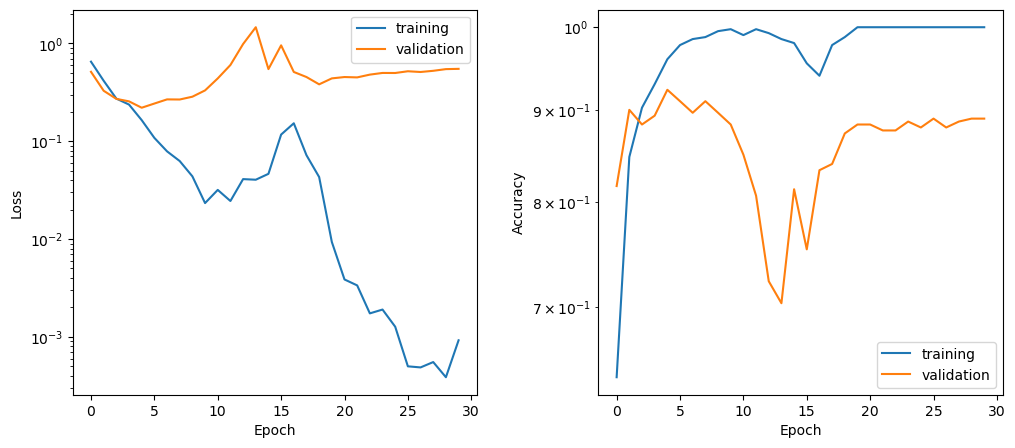

In [12]:
make_plots(history.history)

## Use the model to predict on the holdout set

In [13]:
# Get model predictions
predictions = model.predict(test_dataset)  # Returns probabilities for each class

# threshold the predictions?
predicted_labels = (predictions > 0.5).astype(int)  # Assuming threshold at 0.5 for binary classification

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


### Visualize the results

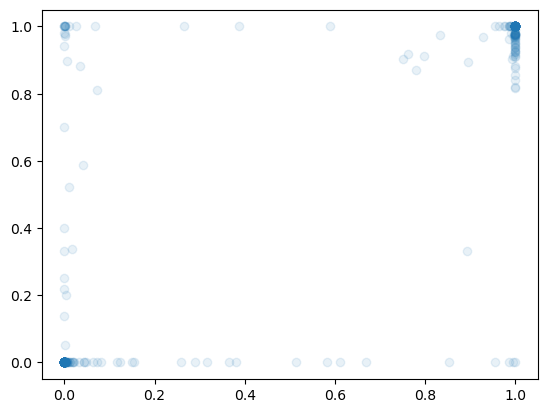

In [14]:
f,ax = plt.subplots()
ax.scatter(predictions, df.iloc[test_idx]['t04_spiral_a08_spiral_debiased'], alpha=0.1)

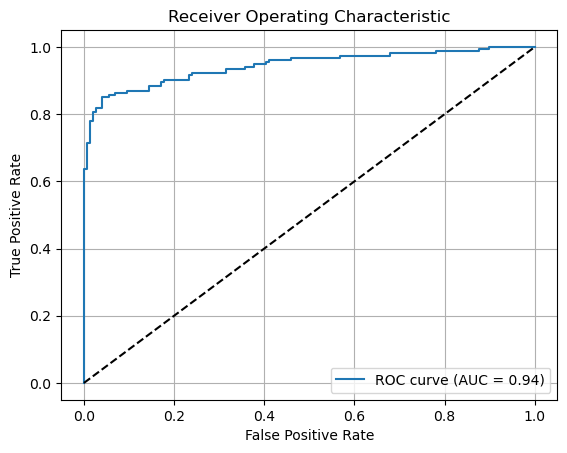

Youden's best threshold = 0.7503342628479004


In [15]:
# check the ROC curve
fpr, tpr, thresholds = roc_curve(df.iloc[test_idx]['label'], predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Youden's J = TPR - FPR
# Pick the threshold where J is maximized
best_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"Youden's best threshold = {best_threshold}")

In [16]:
# print out some sklearn metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)
conf_matrix = confusion_matrix(test_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8933333333333333
Precision: 0.9295774647887324
Recall: 0.8571428571428571
F1 Score: 0.8918918918918919
Confusion Matrix:
[[136  10]
 [ 22 132]]


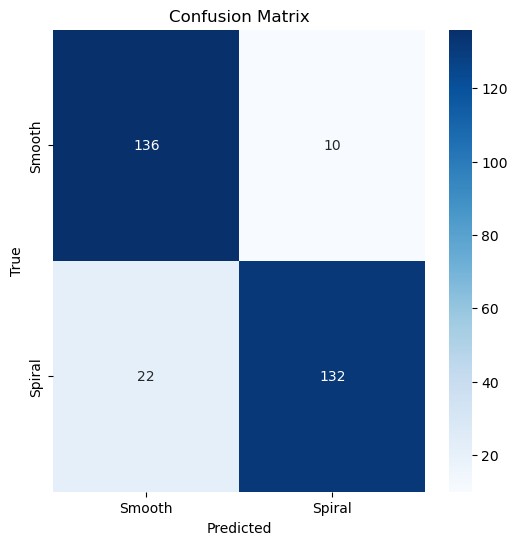

In [17]:
# plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Smooth', 'Spiral'], yticklabels=['Smooth', 'Spiral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

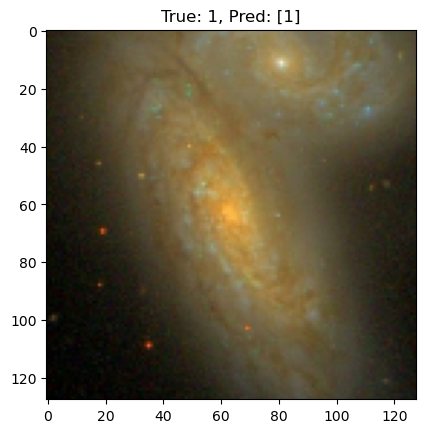

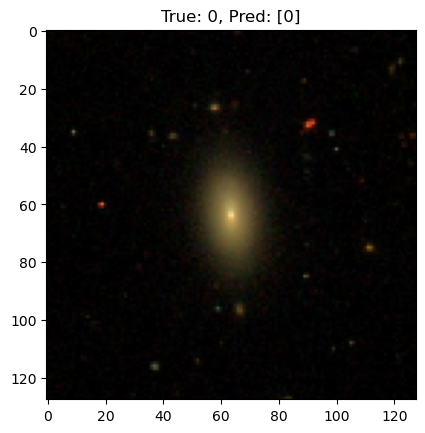

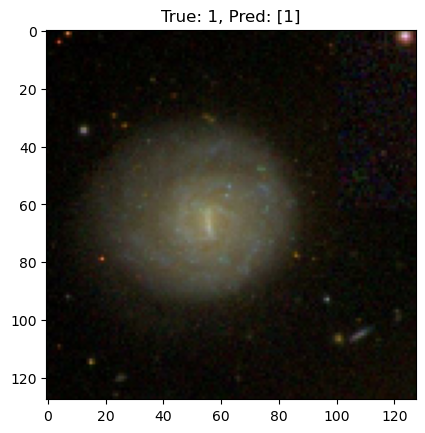

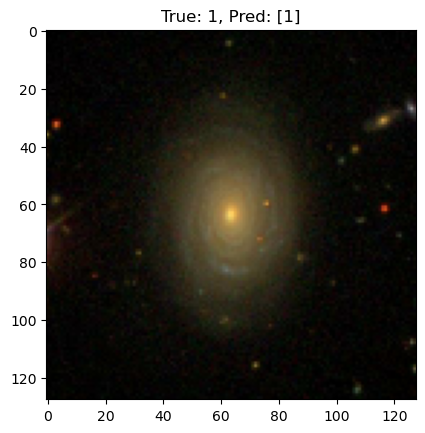

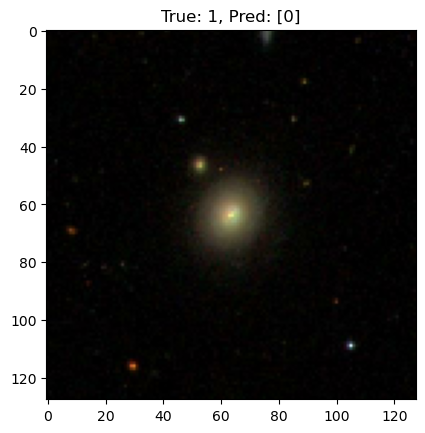

In [18]:
# plot a few images to check visually
for idx in random.sample(range(len(test_idx)), 5):
    image_path = test_paths[idx]
    true_label = test_labels[idx]
    predicted_label = predicted_labels[idx]
    
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image.numpy().astype("float32") / 255.0
    
    plt.imshow(image)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.show()

## Try doing the same thing but with pytorch

In [19]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm  # for progress bar


In [20]:
df.head()

,id,image,specobjid,rastring,decstring,t04_spiral_a08_spiral_debiased,t01_smooth_or_features_a01_smooth_debiased,label,image_path
0,0,images/GZ2_00000.jpg,1802674929645152256,10:43:57.70,+11:42:13.6,0.952,0.00200,1,data/galaxyzoo/images/GZ2_00000.jpg
1,1,images/GZ2_00001.jpg,1387142815909177344,12:30:40.65,+09:00:56.4,0.222,0.88216,0,data/galaxyzoo/images/GZ2_00001.jpg
2,2,images/GZ2_00002.jpg,1489568922213574656,14:03:12.53,+54:20:56.2,1.000,0.00000,1,data/galaxyzoo/images/GZ2_00002.jpg
3,3,images/GZ2_00003.jpg,1606768893613860864,10:13:50.52,+38:45:53.6,0.000,0.86900,0,data/galaxyzoo/images/GZ2_00003.jpg
4,4,images/GZ2_00004.jpg,1809324500555163648,11:40:58.75,+11:28:16.1,0.977,0.00000,1,data/galaxyzoo/images/GZ2_00004.jpg


In [21]:
class GalaxyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.df.iloc[idx]['label'], dtype=torch.float32)
        return image, label

In [22]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# training
p_train_dataset = GalaxyDataset(df.iloc[train_idx], transform=transform)
p_train_dataloader = DataLoader(p_train_dataset, batch_size=32, shuffle=False) #already shuffled above

# validating
p_val_dataset = GalaxyDataset(df.iloc[val_idx], transform=transform)
p_val_dataloader = DataLoader(p_val_dataset, batch_size=32, shuffle=False) #already shuffled above

# testing
p_test_dataset = GalaxyDataset(df.iloc[test_idx], transform=transform)
p_test_dataloader = DataLoader(p_test_dataset, batch_size=32, shuffle=False) #already shuffled above


### Create the pytorch model

Following the same steps as above using Keras

In [23]:
class SimpleGalaxyCNN(nn.Module):
    def __init__(self):
        super(SimpleGalaxyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)  # Output single logit for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, 32]
        x = x.view(-1, 32 * 32 * 32)          # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x  # We'll apply sigmoid later in the loss function

In [24]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model
p_model = SimpleGalaxyCNN().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.001)

Using device: cuda


### Train the model

In [27]:
# number of epochs
num_epochs = 30  

# for my plotting function
p_history = {'loss':[], 'val_loss':[], 'accuracy':[], 'val_accuracy':[]}

for epoch in range(num_epochs):

# ---------- Training ----------
    p_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(p_train_dataloader, desc=f"Epoch {epoch+1} Training"):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape: [B] -> [B, 1] to match output

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = p_model(images)  # raw logits

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and update
        loss.backward()
        optimizer.step()

        # Track loss
        train_loss += loss.item() * images.size(0)

        # Compute accuracy
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / train_total
    train_acc = train_correct / train_total

    # ---------- Validation ----------
    p_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # disables gradient tracking for speed and memory savings.
    with torch.no_grad(): 
        for images, labels in tqdm(p_val_dataloader, desc=f"Epoch {epoch+1} Validation"):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = p_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")


    p_history['loss'].append(avg_train_loss)
    p_history['accuracy'].append(train_acc)
    p_history['val_loss'].append(avg_val_loss)
    p_history['val_accuracy'].append(val_acc)

Epoch 1 Validation: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch 1: Train Loss: 0.4685, Train Acc: 0.8025, Val Loss: 0.3984, Val Acc: 0.8533


Epoch 2 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch 2: Train Loss: 0.3331, Train Acc: 0.8650, Val Loss: 0.2512, Val Acc: 0.9167


Epoch 3 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 3: Train Loss: 0.2695, Train Acc: 0.9300, Val Loss: 0.2430, Val Acc: 0.9000


Epoch 4 Validation: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch 4: Train Loss: 0.2211, Train Acc: 0.9250, Val Loss: 0.2176, Val Acc: 0.9267


Epoch 5 Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Epoch 5: Train Loss: 0.1724, Train Acc: 0.9575, Val Loss: 0.2032, Val Acc: 0.9200


Epoch 6 Validation: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch 6: Train Loss: 0.1577, Train Acc: 0.9525, Val Loss: 0.2065, Val Acc: 0.9333


Epoch 7 Validation: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 7: Train Loss: 0.1380, Train Acc: 0.9600, Val Loss: 0.1960, Val Acc: 0.9300


Epoch 8 Validation: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Epoch 8: Train Loss: 0.1176, Train Acc: 0.9625, Val Loss: 0.2074, Val Acc: 0.9200


Epoch 9 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch 9: Train Loss: 0.1028, Train Acc: 0.9800, Val Loss: 0.2262, Val Acc: 0.9200


Epoch 10 Validation: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Epoch 10: Train Loss: 0.0987, Train Acc: 0.9700, Val Loss: 0.2806, Val Acc: 0.9067


Epoch 11 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 11: Train Loss: 0.0686, Train Acc: 0.9800, Val Loss: 0.2616, Val Acc: 0.9167


Epoch 12 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Epoch 12: Train Loss: 0.0504, Train Acc: 0.9900, Val Loss: 0.3064, Val Acc: 0.9133


Epoch 13 Validation: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 13: Train Loss: 0.0417, Train Acc: 0.9875, Val Loss: 0.3358, Val Acc: 0.9067


Epoch 14 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Epoch 14: Train Loss: 0.0342, Train Acc: 0.9875, Val Loss: 0.3336, Val Acc: 0.9033


Epoch 15 Validation: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Epoch 15: Train Loss: 0.0208, Train Acc: 0.9925, Val Loss: 0.3827, Val Acc: 0.9000


Epoch 16 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 16: Train Loss: 0.0154, Train Acc: 0.9975, Val Loss: 0.4284, Val Acc: 0.9000


Epoch 17 Validation: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Epoch 17: Train Loss: 0.0151, Train Acc: 0.9950, Val Loss: 0.4270, Val Acc: 0.8933


Epoch 18 Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Epoch 18: Train Loss: 0.0113, Train Acc: 1.0000, Val Loss: 0.4406, Val Acc: 0.8967


Epoch 19 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Epoch 19: Train Loss: 0.0081, Train Acc: 1.0000, Val Loss: 0.4694, Val Acc: 0.9000


Epoch 20 Validation: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Epoch 20: Train Loss: 0.0163, Train Acc: 0.9925, Val Loss: 0.4379, Val Acc: 0.9033


Epoch 21 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Epoch 21: Train Loss: 0.0102, Train Acc: 1.0000, Val Loss: 0.4430, Val Acc: 0.9067


Epoch 22 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Epoch 22: Train Loss: 0.0080, Train Acc: 1.0000, Val Loss: 0.5788, Val Acc: 0.8767


Epoch 23 Validation: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch 23: Train Loss: 0.0071, Train Acc: 1.0000, Val Loss: 0.5056, Val Acc: 0.8933


Epoch 24 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch 24: Train Loss: 0.0039, Train Acc: 1.0000, Val Loss: 0.6152, Val Acc: 0.8833


Epoch 25 Validation: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Epoch 25: Train Loss: 0.0028, Train Acc: 1.0000, Val Loss: 0.5425, Val Acc: 0.8933


Epoch 26 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Epoch 26: Train Loss: 0.0020, Train Acc: 1.0000, Val Loss: 0.5840, Val Acc: 0.8933


Epoch 27 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch 27: Train Loss: 0.0019, Train Acc: 1.0000, Val Loss: 0.5824, Val Acc: 0.8967


Epoch 28 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Epoch 28: Train Loss: 0.0031, Train Acc: 0.9975, Val Loss: 0.5987, Val Acc: 0.8867


Epoch 29 Validation: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 29: Train Loss: 0.0018, Train Acc: 1.0000, Val Loss: 0.6193, Val Acc: 0.8900


Epoch 30 Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

Epoch 30: Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.6076, Val Acc: 0.8900


(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Loss'>,
        <Axes: xlabel='Epoch', ylabel='Accuracy'>], dtype=object))

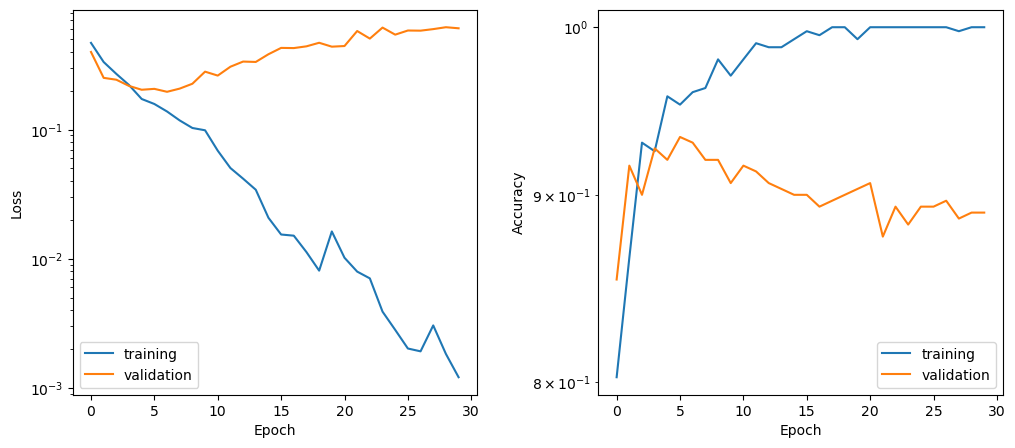

In [28]:
make_plots(p_history)

### Use the model to predict labels on the holdout set

In [29]:
p_model.eval()  # set model to evaluation mode
p_all_preds = []
p_all_probs = []
p_all_labels = []

with torch.no_grad():
    for images, labels in p_test_dataloader:
        images = images.to(device)
        outputs = p_model(images)
        probs = torch.sigmoid(outputs)  # convert logits to probabilities
        preds = (probs > 0.5).float()  # binary predictions (0 or 1)

        p_all_probs.append(probs.cpu())
        p_all_preds.append(preds.cpu())
        p_all_labels.append(labels)

# Concatenate all batches
p_all_probs = torch.cat(p_all_probs).squeeze().numpy()
p_all_preds = torch.cat(p_all_preds).squeeze().numpy()
p_all_labels = torch.cat(p_all_labels).squeeze().numpy()


### Visualize the results

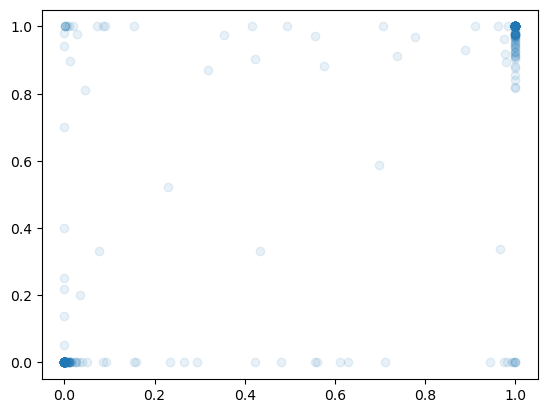

In [30]:
f,ax = plt.subplots()
ax.scatter(p_all_probs, df.iloc[test_idx]['t04_spiral_a08_spiral_debiased'], alpha=0.1)

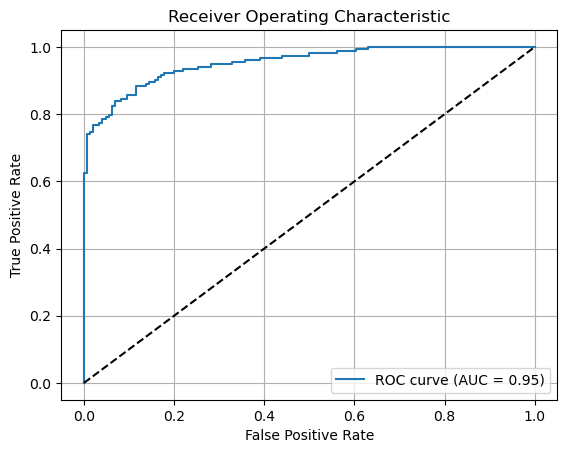

Youden's best threshold = 0.6973679661750793


In [31]:
# check the ROC curve
fpr, tpr, thresholds = roc_curve(df.iloc[test_idx]['label'], p_all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Youden's J = TPR - FPR
# Pick the threshold where J is maximized
best_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"Youden's best threshold = {best_threshold}")

In [32]:
# print out some sklearn metrics
accuracy = accuracy_score(test_labels, p_all_preds)
precision = precision_score(test_labels, p_all_preds)
recall = recall_score(test_labels, p_all_preds)
f1 = f1_score(test_labels, p_all_preds)
conf_matrix = confusion_matrix(test_labels, p_all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8766666666666667
Precision: 0.903448275862069
Recall: 0.8506493506493507
F1 Score: 0.8762541806020067
Confusion Matrix:
[[132  14]
 [ 23 131]]


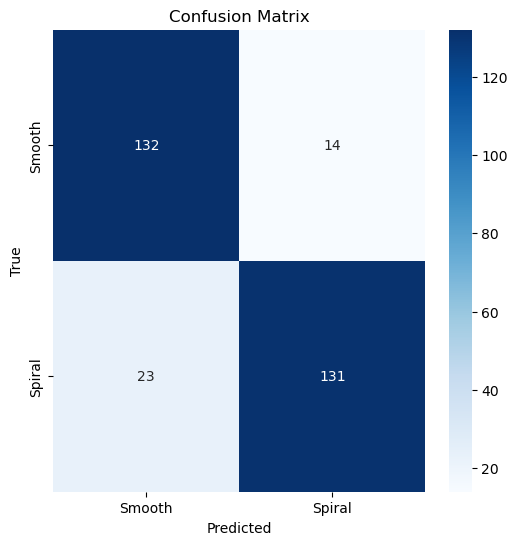

In [33]:
# plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Smooth', 'Spiral'], yticklabels=['Smooth', 'Spiral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

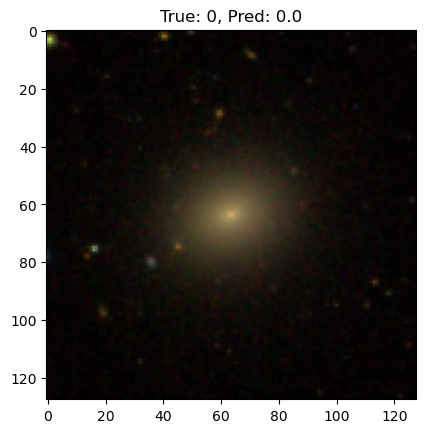

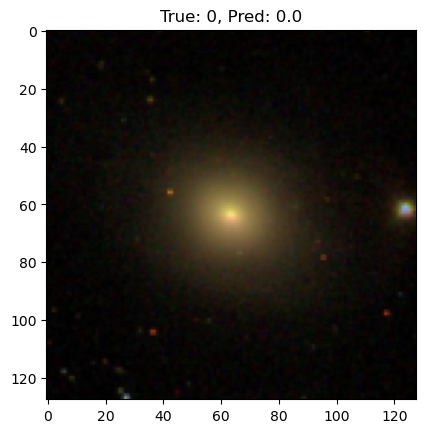

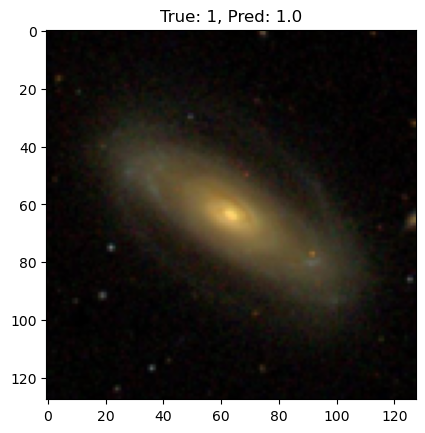

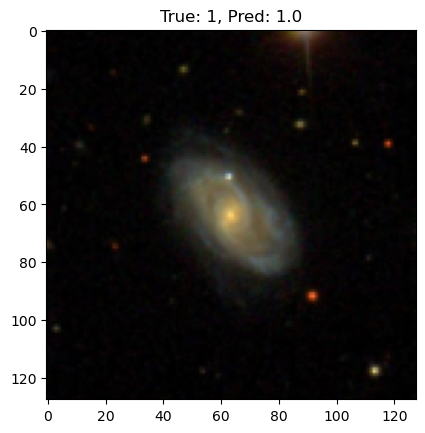

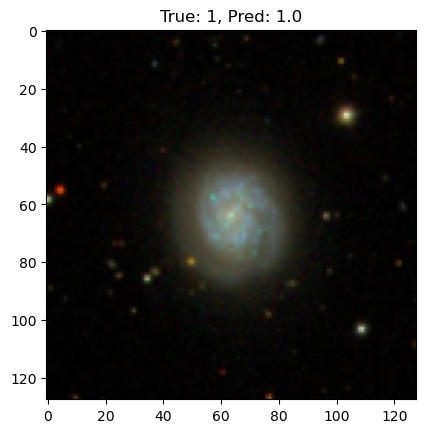

In [36]:
# plot a few images to check visually

p_model.eval()

for idx in random.sample(range(len(test_idx)), 5):
    image_path = test_paths[idx]
    true_label = test_labels[idx]
    predicted_label = p_all_preds[idx]
    
    # Read and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((128, 128))  # Resize to match model input
    image = np.array(image).astype("float32") / 255.0  

    
    plt.imshow(image)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.show()

# My Conclusions

- I prefer tensorflow/keras over pytorch (at least for this); it is faster and the code is cleaner
- Both methods seems do have a similar quality of results
- This is super cool!

## Thoughts from ChatGPT

>My prompt: I successfully ran the CNN model on the galaxyzoo data using tensorflow/keras and pytorch.  Are there any additional steps that you would recommend I learn related to this CNN exploration (either using tensorflow/keras or pytorch)?

You're very welcome — and congratulations on getting your Galaxy Zoo CNN working in both TensorFlow/Keras and PyTorch! That’s a solid achievement that gives you a strong foundation in supervised deep learning for image classification.

Now that you’ve completed the end-to-end pipeline, here are some meaningful next steps you can explore to deepen your understanding and skillset:

---

### 🚀 **1. Model Performance Improvements**

* **Data Augmentation**:

  * Improve generalization by applying random transformations (e.g., flips, rotations).
  * Use `ImageDataGenerator` (Keras) or `torchvision.transforms` (PyTorch).

* **Learning Rate Scheduling**:

  * Implement learning rate decay or schedulers like `ReduceLROnPlateau` or `StepLR`.

* **Early Stopping**:

  * Monitor validation loss to stop training when performance plateaus (Keras makes this easy).

---

### 🧪 **2. Evaluation & Analysis**

* **Confusion Matrix & Classification Report**:

  * Use `sklearn.metrics.classification_report()` and `confusion_matrix()` to break down performance.

* **ROC Curve and AUC Score**:

  * Evaluate how well your model distinguishes classes across thresholds.

* **Error Analysis**:

  * Visualize and investigate misclassified images to understand failure modes.

---

### 🧠 **3. Architecture Exploration**

* **Try Pretrained Models (Transfer Learning)**:

  * Use a pretrained model like `ResNet`, `VGG`, or `MobileNet` as a feature extractor or fine-tune it.
  * Especially useful with limited data like your 1000 images.

* **Deeper Custom CNNs**:

  * Add more layers or explore batch normalization, skip connections, or custom blocks.

---

### 📦 **4. Model Export and Deployment**

* **Save/Load Model**:

  * Save weights and load them later to resume or deploy your model.
  * Use `model.save()` (Keras) or `torch.save()` / `torch.load()` (PyTorch).

* **Convert for Deployment**:

  * Export to `ONNX` or `TensorFlow Lite` if you're interested in using the model on web/mobile.

---

### 📈 **5. Experiment Management**

* **Logging with TensorBoard or Weights & Biases**:

  * Track experiments, metrics, and visualizations.

* **Hyperparameter Tuning**:

  * Try `Keras Tuner`, `Optuna`, or simple grid/random search to optimize performance.

---

### 🌌 **6. Domain-Specific Ideas (Astronomy-focused)**

* **Morphology Regression**:

  * Instead of classifying spiral vs. smooth, predict the continuous probability score (regression).

* **Multi-label Classification**:

  * Predict multiple features per galaxy (e.g., bar presence, edge-on, merger indicators).

* **Compare with Simulated Data**:

  * Use Galaxy Zoo synthetic data or SDSS simulations to test robustness.



# Test using ResNet

In [37]:
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [64]:
# Choose one:
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) # works MUCH better

# Freeze base model if you want feature extraction instead of fine-tuning
base_model.trainable = False

# Add your own head
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
r_model = Model(inputs, outputs)

# Compile
r_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

r_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [65]:
# train the model
AUTOTUNE = tf.data.AUTOTUNE
r_history = r_model.fit(
    train_dataset.prefetch(AUTOTUNE),
    validation_data=val_dataset.prefetch(AUTOTUNE),
    epochs=30
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.5062 - loss: 0.7579 - val_accuracy: 0.8200 - val_loss: 0.4911
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7403 - loss: 0.5434 - val_accuracy: 0.8833 - val_loss: 0.3667
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7669 - loss: 0.4540 - val_accuracy: 0.8933 - val_loss: 0.3064
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8463 - loss: 0.3761 - val_accuracy: 0.9100 - val_loss: 0.2698
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8409 - loss: 0.3670 - val_accuracy: 0.9200 - val_loss: 0.2471
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8738 - loss: 0.3124 - val_accuracy: 0.9200 - val_loss: 0.2355
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8681 - loss: 0.3067 - val_accuracy: 0.9267 - val_loss: 0.2223
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8772 - loss: 0.3082 - val_accuracy: 0.9233 - 

In [66]:
# fine tuning (optional)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile with a lower learning rate
r_model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune (small number of epochs)
r_history_finetuned = r_model.fit(
    train_dataset.prefetch(AUTOTUNE),
    validation_data=val_dataset.prefetch(AUTOTUNE),
    epochs=30
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 891ms/step - accuracy: 0.5344 - loss: 1.2083 - val_accuracy: 0.9200 - val_loss: 0.1969
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6760 - loss: 0.6589 - val_accuracy: 0.9167 - val_loss: 0.2313
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8131 - loss: 0.3746 - val_accuracy: 0.9133 - val_loss: 0.2510
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9165 - loss: 0.2276 - val_accuracy: 0.9100 - val_loss: 0.2631
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9477 - loss: 0.1694 - val_accuracy: 0.9100 - val_loss: 0.2643
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9749 - loss: 0.1422 - val_accuracy: 0.9133 - val_loss: 0.2607
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9791 - loss: 0.1265 - val_accuracy: 0.9133 - val_loss: 0.2605
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9901 - loss: 0.0823 - val_accuracy: 0.9133 -

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Loss'>,
        <Axes: xlabel='Epoch', ylabel='Accuracy'>], dtype=object))

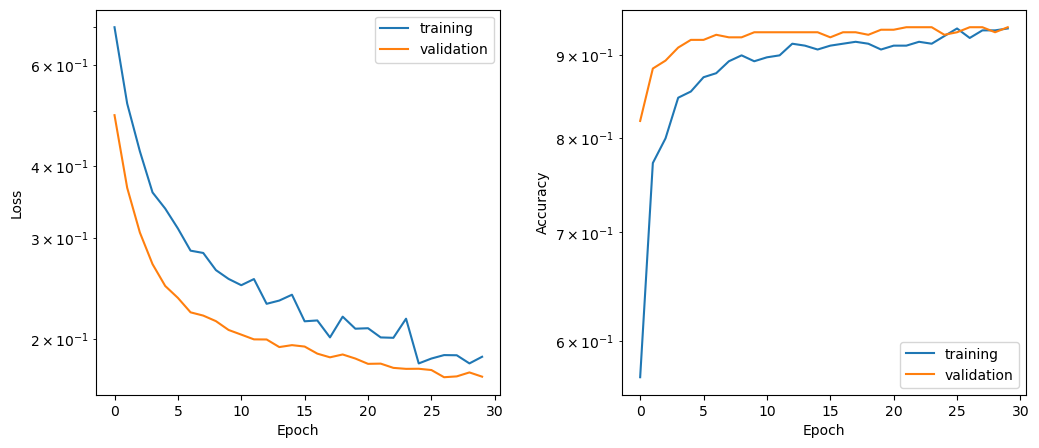

In [67]:
make_plots(r_history.history)

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Loss'>,
        <Axes: xlabel='Epoch', ylabel='Accuracy'>], dtype=object))

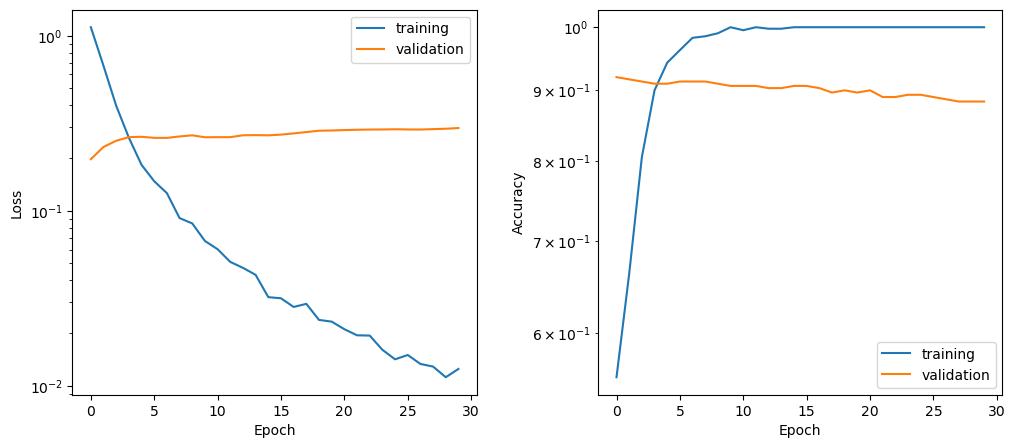

In [68]:
make_plots(r_history_finetuned.history)

In [69]:
# Get model predictions
r_predictions = r_model.predict(test_dataset)  
r_predicted_labels = (r_predictions > 0.5).astype(int)  

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step


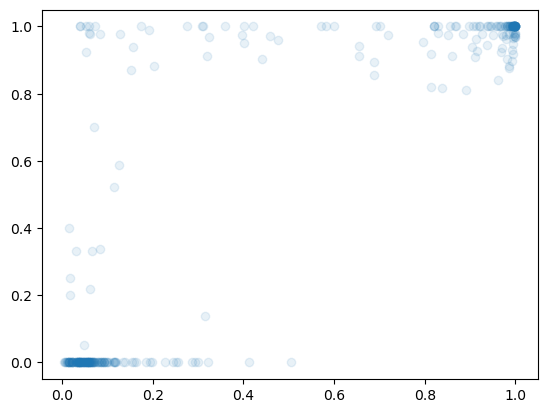

In [70]:
f,ax = plt.subplots()
ax.scatter(r_predictions, df.iloc[test_idx]['t04_spiral_a08_spiral_debiased'], alpha=0.1)

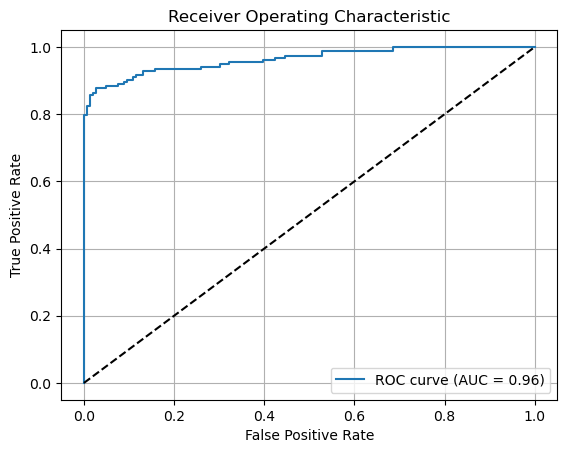

Youden's best threshold = 0.3077731728553772


In [71]:
# check the ROC curve
fpr, tpr, thresholds = roc_curve(df.iloc[test_idx]['label'], r_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Youden's J = TPR - FPR
# Pick the threshold where J is maximized
best_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"Youden's best threshold = {best_threshold}")

In [72]:
# print out some sklearn metrics
accuracy = accuracy_score(test_labels, r_predicted_labels)
precision = precision_score(test_labels, r_predicted_labels)
recall = recall_score(test_labels, r_predicted_labels)
f1 = f1_score(test_labels, r_predicted_labels)
conf_matrix = confusion_matrix(test_labels, r_predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8933333333333333
Precision: 0.9919354838709677
Recall: 0.7987012987012987
F1 Score: 0.8848920863309353
Confusion Matrix:
[[145   1]
 [ 31 123]]


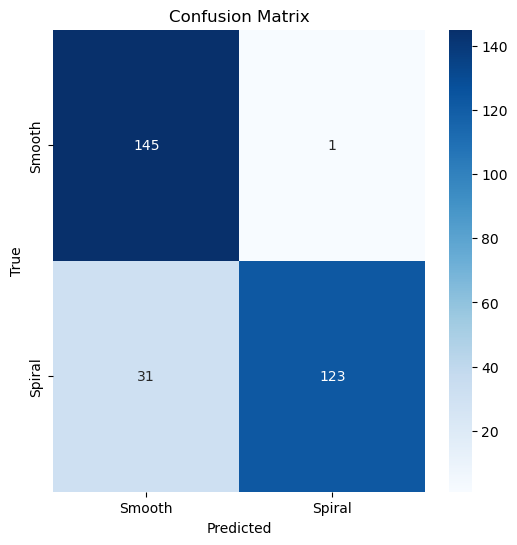

In [73]:
# plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Smooth', 'Spiral'], yticklabels=['Smooth', 'Spiral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

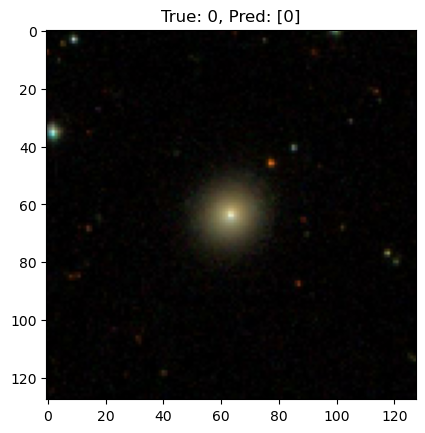

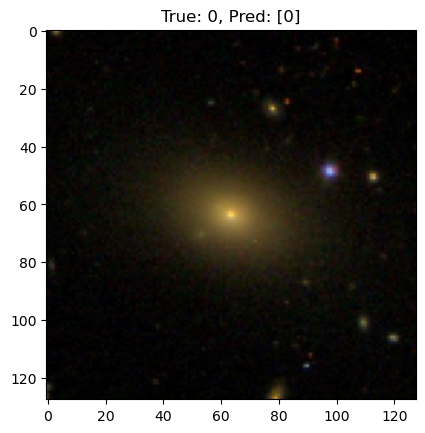

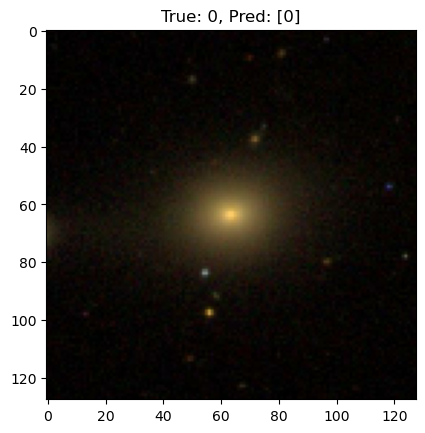

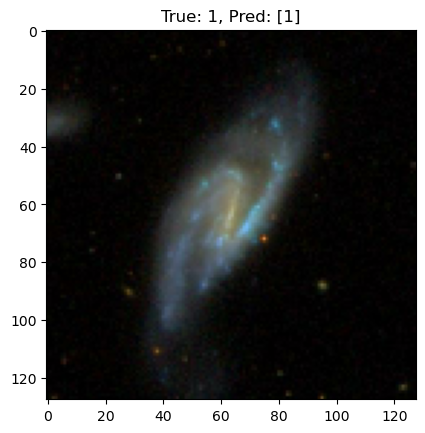

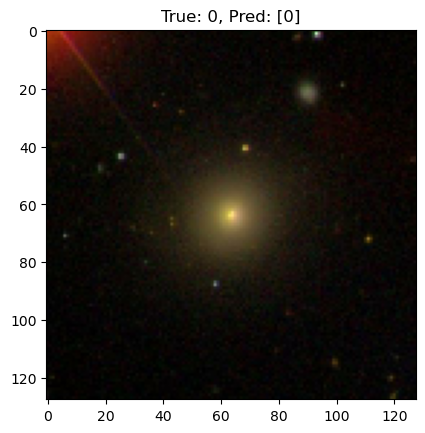

In [74]:
# plot a few images to check visually
for idx in random.sample(range(len(test_idx)), 5):
    image_path = test_paths[idx]
    true_label = test_labels[idx]
    predicted_label = r_predicted_labels[idx]
    
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image.numpy().astype("float32") / 255.0
    
    plt.imshow(image)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.show()

# Possible extension: multi-modal models

Example from ChatGPT

> My prompt: Now I'd like to build a multi-modal model the ideally includes a CNN.  Let's imagine that in addition to my images I have spectra and maybe also some additional features, like photometry or some other numerical parameters.  How would I do this with tensorflow / keras?

Great question—this is an excellent opportunity to build a **multi-input (multi-modal) model** using **Keras' Functional API**, which is designed for exactly this kind of setup.

---

## 🧠 Concept Overview

You want a model that takes:

1. **Image input** → processed with a **CNN** (e.g., ResNet or your custom CNN)
2. **Spectral input** → can be treated as a **1D array** or image and processed with **1D-CNN** or **Dense layers**
3. **Tabular features** → go through **Dense layers**

These three branches will then be **merged and processed together**, followed by a final output layer.

---

## 🧰 Architecture Sketch in Keras

```python
from tensorflow.keras import layers, models, Input, Model

# --- Image input (e.g., galaxy image) ---
image_input = Input(shape=(128, 128, 3), name='image_input')
x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
image_branch = layers.Dropout(0.3)(x)

# --- Spectra input (1D array) ---
spectra_input = Input(shape=(500,), name='spectra_input')  # Example: 500 wavelength bins
y = layers.Dense(128, activation='relu')(spectra_input)
y = layers.Dense(64, activation='relu')(y)
spectra_branch = layers.Dropout(0.3)(y)

# --- Additional numerical features (e.g., photometry) ---
tabular_input = Input(shape=(10,), name='tabular_input')  # Example: 10 features
z = layers.Dense(32, activation='relu')(tabular_input)
z = layers.Dense(16, activation='relu')(z)
tabular_branch = z

# --- Combine all branches ---
combined = layers.concatenate([image_branch, spectra_branch, tabular_branch])
combined = layers.Dense(64, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
output = layers.Dense(1, activation='sigmoid')(combined)

# --- Final model ---
model = Model(inputs=[image_input, spectra_input, tabular_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```

---

## 🗂️ Input Structure for Training

You will need to pass data like this:

```python
history = model.fit(
    x={
        'image_input': image_array,        # shape: (batch_size, 128, 128, 3)
        'spectra_input': spectra_array,    # shape: (batch_size, 500)
        'tabular_input': tabular_array     # shape: (batch_size, 10)
    },
    y=labels,
    validation_split=0.2,
    batch_size=32,
    epochs=10
)
```

---

## 📌 Tips

* Normalize each input type appropriately.
* Use dropout and batch norm to avoid overfitting, especially if your dataset isn’t huge.
* You can replace the CNN with a **pretrained model** (e.g., MobileNet) if desired.
* Use the **Functional API** whenever you have multiple inputs.
